# Modelo HJM com parametrização de Musiela

n = numero de fatores do modelo HJM (3 ou 2 fatores).

O algoritmo é separado em duas partes, uma que calcula o drift em um passo de tempo determinado e o outro que anda pelo tempo e atualiza a curva a cada passo.

Primeiro preciso criar a função que calcula o drif

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky
INPUT_PATH = "D:\\Documents\\JupyterNB\\tese_fgv\\dados\\dados_tratados\\Nominal\\"
INPUT_GREGAS = "D:\\Documents\\JupyterNB\\tese_fgv\\dados\\dados_tratados\\"

\begin{equation*}
\hat{\mu}(t_{i-1}, \tau_{j}) = \dfrac{1}{2(\tau_{j+1}-\tau_{j})}
\bigl[\sum_{k=1}^n(\sum_{l=0}^j\hat{\sigma}_{k}(t_{i-1}, \tau_{l})[\tau_{l+1}-\tau_{l}])^2)
- \sum_{k=1}^n(\sum_{l=0}^{j-1}\hat{\sigma}_{k}(t_{i-1}, \tau_{l})[\tau_{l+1}-\tau_{l}])^2\bigr]
\end{equation*}

\begin{equation*}
\sigma_{k}(t, \tau) = (\alpha_{i}(t) + \beta_{i}(t)\tau)e^{\gamma_{i}(t)\tau} + \delta_{i}(t)
\end{equation*}

In [146]:
pdGregas = pd.read_csv(INPUT_GREGAS + 'gregas2.csv',header = 0)
gregas = pdGregas.values.tolist()

In [147]:
# gregas= [[0.009955,  -0.006341, -0.017710,  0.004642],
#          [0.009954, -0.006499, -0.017375,  0.004296],
#          [0.009954, -0.006571, -0.017206,  0.004197]]
txInicial = pd.read_csv(INPUT_PATH + 'fwdNominal_2017.csv', index_col='Dia')
txInicial = txInicial.tail(1)
txInicial = txInicial.reset_index()
# tVctos = list(map(int, txInicial.columns))
tVctos = txInicial.columns[1:]
# print(txInicial)
txsCalculadas = [[tx] for tx in txInicial.loc[:, tVctos].values.tolist()[0]]
# print(txsCalculadas)

In [148]:
# def muChapeu_old(vctoTal, tVctos, gregas):
#     tVctos = list(map(int, tVctos))
#     sum11, sum22 = 0, 0
#     # condicao para calcular a taxa do ultimo vencimento tal
#     if (vctoTal == tVctos[(len(tVctos) - 1)]):
#         fator = 0
#     else:
#         fator = (1 / (2 * (tVctos[tVctos.index(vctoTal) + 1] - vctoTal)))
        
#         for key_grega, pc in enumerate(gregas): # contagem doscomponentes principais (3 ou 2 componentes)
#             sum1, sum2 = 0, 0
#             for key_vcto, vcto in enumerate(tVctos):
#                 if vcto <= vctoTal:
#                     sum1 +=funcVol3(pc, vcto) * (tVctos[key_vcto + 1] - tVctos[key_vcto])
#                 if vcto < vctoTal:
#                     sum2 +=funcVol3(pc, vcto) * (tVctos[key_vcto + 1] - tVctos[key_vcto])
#             sum11 += (sum1 **2)
#             sum22 += (sum2 **2)
            
#     return (fator * (sum11 - sum22))

def muChapeu(vctoTal, tVctos, gregas):
    tVctos = list(map(int, tVctos))
    tVctosNovo = tVctos[1:] # usado para o calculo para j > 0
    sum11, sum22 = 0, 0
    # condicao para calcular a taxa do ultimo vencimento tal
    if (vctoTal == tVctos[(len(tVctos) - 1)]):
        fator = 0
    else:
        fator = (1 / (2 * (tVctos[tVctos.index(vctoTal) + 1] - vctoTal)))
#         print(fator, (tVctos[tVctos.index(vctoTal) + 1] - vctoTal))
        for key_grega, pc in enumerate(gregas): # contagem doscomponentes principais (3 ou 2 componentes)
            sum1, sum2 = 0, 0
            # para o primeiro tal (j = 0) ja vou iniciar os valores de sum1 e sum2
            sum1 +=funcVol3(pc, tVctos[0]) * (tVctos[1] - tVctos[0])
            sum2 +=funcVol3(pc, tVctos[0]) * (tVctos[1] - tVctos[0])
#             print(funcVol3(pc, tVctos[0]) * (tVctos[1] - tVctos[0]))
            # agora para j = 1 ate o final
            for key_vcto, vcto in enumerate(tVctosNovo):            
#                 print(vcto, vctoTal)
                if vcto <= vctoTal:
#                     print("sum1")
                    sum1 +=funcVol3(pc, vcto) * (tVctosNovo[key_vcto + 1] - tVctosNovo[key_vcto])
#                     print(vcto, "sum1","sigma", funcVol3(pc, vcto),"deltaTal", (tVctos[key_vcto + 1] - tVctos[key_vcto]), funcVol3(pc, vcto) * (tVctos[key_vcto + 1] - tVctos[key_vcto]))
#                     print(pc, vcto, funcVol3(pc, vcto) * (tVctos[key_vcto + 1] - tVctos[key_vcto]))
                if vcto < vctoTal:
#                     print("sum2")
                    sum2 +=funcVol3(pc, vcto) * (tVctosNovo[key_vcto + 1] - tVctosNovo[key_vcto])
#                     print(vcto, "sum2", funcVol3(pc, vcto) * (tVctos[key_vcto + 1] - tVctos[key_vcto]))
#             print(pc,sum1, sum2)
            sum11 += (sum1 **2)
            sum22 += (sum2 **2)
#     print(fator, sum11, sum22)
    return (fator * (sum11 - sum22))

def funcVol3(coeffs, t):
    # Funcao para minimizar e encontrar os valores de alpha_i, beta_i, gamma_i, delta_i
    vol = []
    vol = (coeffs[0] + np.dot(coeffs[1],t)) * np.exp(np.dot(coeffs[2],t)) + coeffs[3]
    return vol


$$ \hat{r}(t_{i}, \tau_{j}) = 
\hat{r}(t_{i-1}, \tau_{j}) + \bigl[
\dfrac{\hat{r}(t_{i-1}, \tau_{j+1}) - \hat{r}(t_{i-1}, \tau{j})}
{\tau_{j+1}-\tau{j}} + \hat{\mu}(t_{i-1}, \tau_{j})\bigr]
(t_{i}-t_{i-1}) + \sum_{k=1}^n \hat{\sigma}_{k}(t_{i-1},\tau_{j})
\sqrt{(t_{i}-t_{i-1})}\hat{Z}_{k}
$$

### Geracao dos numeros aleatorios

se o modelo possuisse um fator so, seria necessario gerar 3 curvas e correlacioná-las com a decomposição de cholesky. 

In [ ]:
num_samples = 360
delta = 1.0
dt = 1.0/360
"""
dt: float
    The time step

delta: float
    delta determines the "speed" of the Brownian motion.  The random variable
    of the position at time t, X(t), has a normal distribution whose mean is
    the position at time t=0 and whose variance is delta**2*t.
          
"""

# The desired covariance matrix.
r = np.array([
        [  3.40, -2.75, -2.00],
        [ -2.75,  5.50,  1.50],
        [ -2.00,  1.50,  1.25]
    ])

# Generate samples from three independent normally distributed random
# variables (with mean 0 and std. dev. 1).
W = norm.rvs(size=(3, num_samples), scale=delta*np.sqrt(dt))

# We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
# the Cholesky decomposition, or the we can construct `c` from the
# eigenvectors and eigenvalues.

# Compute the Cholesky decomposition.
c = cholesky(r, lower=True)

# Convert the data to correlated random variables. 
y = np.dot(c, W)

# covariance of the random variables
np.cov(y)

In [ ]:
plt.plot(y.T)
plt.show()

Entao, para cada fator, serao geradas 3 curvas correlacionadas da forma acima.

In [157]:
Wn = []
Wr = []
Wi = []
for i in range(len(gregas)): # como o modelo possui 3 fatores, preciso gerar 3 curvas para cada fator.
    num_samples = 360
    delta = 1.0
    dt = 1.0  #/num_samples
    """
    dt: float
        The time step

    delta: float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.

    """

    # The desired covariance matrix.
    r = np.array([
            [  3.40, -2.75, -2.00],
            [ -2.75,  5.50,  1.50],
            [ -2.00,  1.50,  1.25]
        ])

    # Generate samples from three independent normally distributed random
    # variables (with mean 0 and std. dev. 1).
    W = norm.rvs(size=(3, num_samples), scale=delta*np.sqrt(dt))

    # We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
    # the Cholesky decomposition, or the we can construct `c` from the
    # eigenvectors and eigenvalues.

    # Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)

    # Convert the data to correlated random variables. 
    y = np.dot(c, W)

    # covariance of the random variables
#     print(np.cov(y))

    Wn.append(y[0,:])
    Wr.append(y[1,:])
    Wi.append(y[2,:])

In [150]:
txsCalculadas

[[0.05167953745553877],
 [0.05301561720702033],
 [0.05438021989256097],
 [0.05572684732695594],
 [0.06701607832791044],
 [0.07368050062788133],
 [0.07962265598565149]]

# PRECISO RESOLVER O PROBLEMA DO MUCHAPEU
- Parece que as iteracoes nao estao corretas, os valores estao ficando muito alto porque as somas de cada uma das partes nao esta sendo feita corretamente.

- os prazos calculados comecam com j = 1
    - o que fazer com a taxa spot? Estou ignorando no calculo o pedaco que utiliza o ponto medio entre a tx atual e a proxima
    - Vctos com prazos de 1800 e 3600 estao resultando num MuChapeu muito alto, fazendo com que a taxa apresente um crescimento constante
    


# Preciso:
    - gerar mais curvas para cada vencimento
    - gerar a curva real da mesma forma que a nominal
        - modelar a curva real
        - calcular as correlacoes entre as curvas
        

In [158]:
deltaTempo = 1/360 # a definir como calcular de um dia para o outro
tVctos = txInicial.columns[1:]
# tVctos = tVctos[2:4]
txsCalculadas = [[tx] for tx in txInicial.loc[:, tVctos].values.tolist()[0]]
for tempoT in range(1,360):
    for keyTal, tal in enumerate(tVctos):
#         print(tal)
        # inicia o valor da tx do tempo tal
        valorTx = 0

        # inicio do calculo da tx tal
        valorTx += txsCalculadas[keyTal][tempoT - 1]
#         print(valorTx)
#         print(tal,keyTal, txsCalculadas[keyTal][tempoT - 1])
        
        # captura qual o proximo vencimento tal
        # condicao para calcular a taxa do ultimo vencimento tal
        if (keyTal == (len(tVctos)-1)):
            valorTx += 0
        else:
            valorTx += ((txsCalculadas[keyTal + 1][tempoT - 1] - txsCalculadas[keyTal][tempoT - 1]) / 
                        (int(tVctos[keyTal + 1]) - int(tVctos[keyTal])) +
                        muChapeu(int(tVctos[keyTal]), tVctos, gregas)) * deltaTempo
#             print(((txsCalculadas[keyTal + 1][tempoT - 1] - txsCalculadas[keyTal][tempoT - 1]) / (int(tVctos[keyTal + 1]) - 
#                   int(tVctos[keyTal])), muChapeu(int(tVctos[keyTal]), tVctos, gregas)), deltaTempo)
#             print(((txsCalculadas[keyTal + 1][tempoT - 1] - txsCalculadas[keyTal][tempoT - 1]) / 
#                         (int(tVctos[keyTal + 1]) - int(tVctos[keyTal])) +
#                         muChapeu(int(tVctos[keyTal]), tVctos, gregas)) * deltaTempo)
            

        # Calcula o valor das sigma_k
        for k, grega in enumerate(gregas):
            valorTx += funcVol3(grega, int(tVctos[keyTal])) * np.sqrt(deltaTempo) * Wn[k][tempoT]
#             print(valorTx,funcVol3(grega, int(tVctos[keyTal])) * np.sqrt(deltaTempo) * Wn[k][tempoT])
#         print(valorTx,funcVol3(grega, int(tVctos[keyTal])) * np.sqrt(deltaTempo) * Wn[k][tempoT])
            
#             print(funcVol3(grega, int(tal)), np.sqrt(deltaTempo), W[k,1])
        txsCalculadas[keyTal].append(valorTx)
#         print(keyTal,txsCalculadas[keyTal])
#     print(txsCalculadas)

    
txsCalculadas = pd.DataFrame.from_dict(dict(zip(tVctos, txsCalculadas)))
# txsCalculadas.columns
txsCalculadas.describe()


,1,30,60,90,360,540,720
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,0.049801,0.051202,0.052613,0.054179,0.065800,0.072727,0.077720
std,0.001102,0.001071,0.001049,0.000950,0.000815,0.000726,0.001114
min,0.047716,0.049131,0.050552,0.052166,0.063860,0.070846,0.075630
25%,0.048849,0.050294,0.051734,0.053427,0.065263,0.072320,0.076753
50%,0.049893,0.051290,0.052689,0.054183,0.065785,0.072747,0.077814
75%,0.050566,0.051946,0.053335,0.054822,0.066327,0.073118,0.078494
max,0.052215,0.053556,0.054924,0.056288,0.067610,0.074398,0.080156


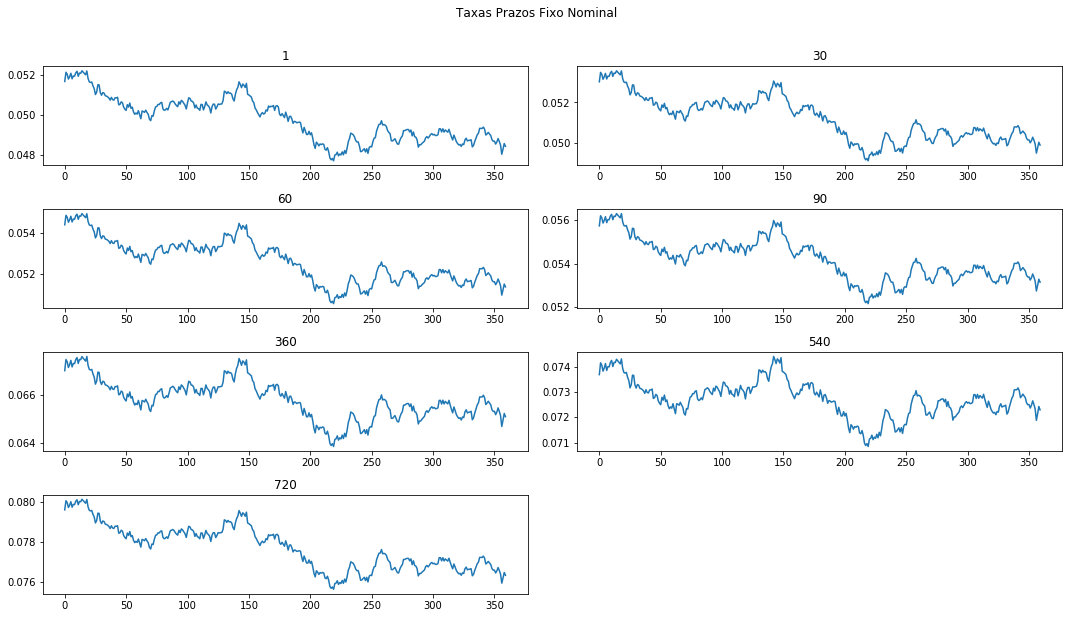

In [159]:
fig = plt.figure(2, figsize=(15, 15))
for key, pz in enumerate(txsCalculadas.columns):
    ax = plt.subplot(len(txsCalculadas.columns), 2, key + 1)
    ax.plot(txsCalculadas[txsCalculadas.columns[key]])
    ax.set_title(pz)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Taxas Prazos Fixo Nominal')
plt.show()


- valor para a taxa de 3600 esta estourando
- valor para 1800 tb

#### Verificar :
 - se o calculo das txs para Prazo Fixo estao corretos (acho que nao, que estou calculando ZCP)
 - Se o calculo do PCA esta resultando gregas consistentes